# Klassifikation des Objekttyps

In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import is_object_dtype

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn.metrics
import xgboost as xgb
import lightgbm as lgb

from sklearn.inspection import permutation_importance

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

from helper_functions import preprocessing
from helper_functions.metrics import *
import datetime
## Bayesian Optimization
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

In [2]:
#read in data
csv_data = pd.read_csv('immo_dev_data.csv')

Für die Klassifikationsaufgabe haben wir folgende Teilaufgaben:

1. Entwickle und vergleiche drei sinnvolle Modelle zur Klassifikation von Immobilien Objekten hinsichtlich `GroupNameDe`. 
2. Was sind sinnvolle Metriken zur Messung der Genaugikeit der Vorhersage im vorliegenden Fall? 
3. Rapportiere diese Metrik(en) mit einer Abschätzung des Fehlers für alle drei Modelle.

## Metriken

Wir beginnen mit 2., den Metriken. Hierfür müssen wir uns als erstes einen Überblick über unsere Zielvariable verschaffen. Schauen wir einmal, wie viele verschiedene Objekttypen es gibt und wie viele Objekte es für jeden Typen gibt.

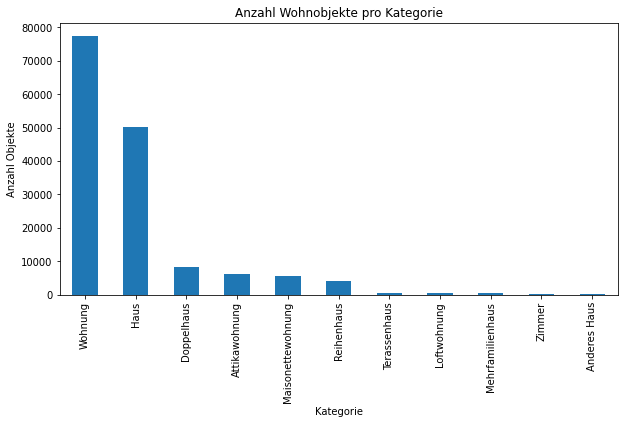

In [3]:
csv_data['GroupNameDe'].value_counts().plot(kind='bar', figsize=(10, 5), rot = 90)
plt.xlabel("Kategorie")
plt.ylabel("Anzahl Objekte")
plt.title("Anzahl Wohnobjekte pro Kategorie")
plt.show()

Man kann im Plot sehr gut erkennen, dass es sich hier im eine ungleichmäsige Verteilung der Kategorien handelt. Da man einige Kategorien gar nicht erkennen kann, schauen wir noch die Zahlen an:

In [4]:
csv_data['GroupNameDe'].value_counts()

Wohnung              77499
Haus                 50265
Doppelhaus            8397
Attikawohnung         6215
Maisonettewohnung     5517
Reihenhaus            4168
Terassenhaus           533
Loftwohnung            474
Mehrfamilienhaus       444
Zimmer                  89
Anderes Haus            26
Name: GroupNameDe, dtype: int64

Die Kategorie *Wohnung* ist mit 77'499 Objekten gegenüber den 26 Objekten in *Anderes Haus* mehr als 2'980 mal öfter vertreten. Insgesammt sind es 153'627 Objekte, von denen 127'764 in den "Top Zwei" der Kategorien vorkommen; das sind 83% aller Objekte. Um ein gutes Modell erstellen zu können, müssen wir diese Verteilung in Betracht ziehen. Somit müssen wir auch eine Metrik auswählen, die das Ganze widerspiegelt.

Die *Accuracy* oder Genauigkeit ist in diesem Fall eine schlechte Metrik. Sie beschreibt, wie viele Objekte richtig klassifiziert wurden. Wenn nur Wohnungen und Häuser korrekt eingeordnet werden und alles andere falsch, ist die Accuracy trotzdem 83%, obwohl unser Modell effektiv nur zwei Kategorien richtig bestimmt.
Aus diesem Grund haben wir uns für den *[F1-Score](https://en.wikipedia.org/wiki/F-score)* entschieden. Genauer gesagt schauen wir uns die Scores pro Kategorie an und den ungewichteten Durchschnitt aller Scores.

## Resampling

Damit die Modelle besser performen, kann man die Trainingsdaten resamplen. Es gibt zwei verschiedene Arten Daten zu resamplen: Under- und Oversampling. 

### Undersampling

Beim Undersampling werden die Daten reduziert. Man entfernt Objekte, die den "grossen" Klassen angehören, und das (optimalerweise) solange, bis überall gleich viele Objekte existieren. Da unsere kleinste Klasse nur 26 Objekte hat, ist diese Methode für unseren Fall nicht sinnvoll.

### Oversampling

Oversampling bedeutet, dem Datensatz werden neue Objekte hinzugefügt um eine "Anzahl"-Balance zwischen allen Klassen herzustellen. Hierfür kann man bestehende Objekte zufällig auswählen und mehrmals hinzufügen bzw. kopieren oder komplett neue Objekte – basierend auf den bereits existierenden – erstellen. Dies funktioniert beispielsweise mit der [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE) Methode. Hiermit werden wir uns auch beschäftigen.

In [5]:
#prepro = preprocessing.preprocessor(train_data, y_var='GroupNameDe')#, cols_to_drop=['StreetAndNr', 'LastUpdate', 'Locality', 'Id', 'Zip'])#, 'Id'])
#prepro.preprocess()
csv_data_fe = csv_data.copy()
csv_data_fe['Zip'] = (csv_data_fe['Zip']/100).astype('int8')
prepro = preprocessing.preprocessor(csv_data_fe, y_var='GroupNameDe', method_to_encode='onehot_encode', cols_to_drop=['Id', 'LastUpdate', 'Locality', 'StreetAndNr', 'Longitude', 'Latitude', 'HouseObject', 'RealEstateTypeId'], numbers_to_encode=['Zip'], test_frac= 0.1)
prepro.preprocess()

X_train = prepro.X_train
X_test = prepro.X_test

y_train = prepro.y_train
y_test = prepro.y_test

In [6]:
ros = RandomOverSampler(random_state = 69)
X_random_, y_random_ = ros.fit_resample(X_train, y_train)
X_random = X_random_.sample(len(X_train), random_state = 69)
y_random = y_random_.iloc[X_random.index]

In [7]:
smote = SMOTE(random_state = 69, sampling_strategy = 'all')
X_smote_, y_smote_ = smote.fit_resample(X_train, y_train)
X_smote = X_smote_.sample(len(X_train), random_state = 69)
y_smote = y_smote_.iloc[X_smote.index]

So siehen die Daten nach dem Resampling aus:

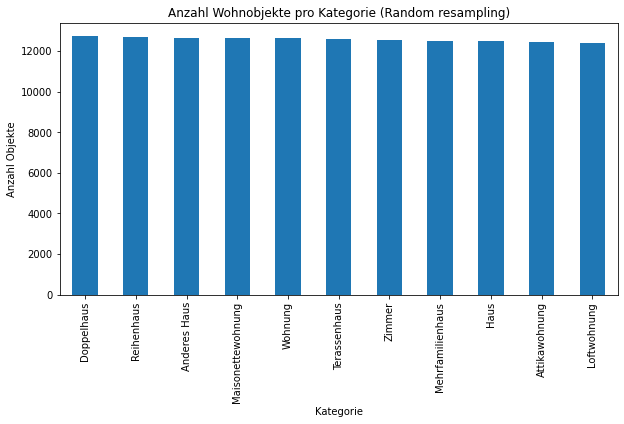

In [8]:
y_random.value_counts().plot(kind='bar', figsize=(10, 5), rot = 90)
plt.xlabel("Kategorie")
plt.ylabel("Anzahl Objekte")
plt.title("Anzahl Wohnobjekte pro Kategorie (Random resampling)")
plt.show()

# Modellauswahl

Weiter geht es mit 1. aus der Aufgabenstellung: Entwickle und vergleiche drei sinnvolle Modelle zur Klassifikation von Immobilien Objekten hinsichtlich `GroupNameDe`.

Wir haben uns für folgende Modelle entschieden: 

- K-Nearest Neighbors
- Random Forrest
- XGBoost
- LightGBM

Als erstes werden die Modelle auf den unveränderten Daten trainiert, danach auf zufällig geresampleten Daten und dann auf den SMOTE Daten. Damit das Training jedoch nicht allzulange dauert, werden von den beiden oversampleten Datasets zufällige Objekte ausgewählt bis diese Datasets gleich gross sind wie das originale.

## K-Nearest Neighbors

In [9]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X = X_train, y = y_train)

KNeighborsClassifier(n_jobs=-1)

In [10]:
knn_rnd = KNeighborsClassifier(n_jobs = -1)
knn_rnd.fit(X = X_random, y = y_random)

KNeighborsClassifier(n_jobs=-1)

In [11]:
knn_smote = KNeighborsClassifier(n_jobs = -1)
knn_smote.fit(X = X_smote, y = y_smote)

KNeighborsClassifier(n_jobs=-1)

### Prediction und F1-Scores

In [12]:
knn_y_pred = knn.predict(X = X_test)
knn_y_pred_rnd = knn_rnd.predict(X = X_test)
knn_y_pred_smote = knn_smote.predict(X = X_test)

In [13]:
print('F1-Score KNN imbalanced Data:')
np.round(sklearn.metrics.f1_score(y_test, knn_y_pred, average = 'macro'), decimals = 3)

F1-Score KNN imbalanced Data:


0.252

In [14]:
print('F1-Score KNN randomly resampled Data:')
np.round(sklearn.metrics.f1_score(y_test, knn_y_pred_rnd, average = 'macro'), decimals = 3)

F1-Score KNN randomly resampled Data:


0.207

In [15]:
print('F1-Score KNN SMOTE resampled Data:')
np.round(sklearn.metrics.f1_score(y_test, knn_y_pred_smote, average = 'macro'), decimals = 3)

F1-Score KNN SMOTE resampled Data:


0.202

## Random Forest

In [16]:
rfc = RandomForestClassifier(n_jobs = -1, random_state = 69)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=69)

In [17]:
rfc_rnd = RandomForestClassifier(n_jobs = -1, random_state = 69)
rfc_rnd.fit(X_random, y_random)

RandomForestClassifier(n_jobs=-1, random_state=69)

In [18]:
rfc_smote = RandomForestClassifier(n_jobs = -1, random_state = 69)
rfc_smote.fit(X_smote, y_smote)

RandomForestClassifier(n_jobs=-1, random_state=69)

### Prediction und F1-Scores

In [19]:
rfc_y_pred = rfc.predict(X = X_test)
rfc_y_pred_rnd = rfc_rnd.predict(X = X_test)
rfc_y_pred_smote = rfc_smote.predict(X = X_test)

In [20]:
print('F1-Score Random Forest imbalanced Data:')
np.round(sklearn.metrics.f1_score(y_test, rfc_y_pred, average = 'macro'), decimals = 3)

F1-Score Random Forest imbalanced Data:


0.364

In [21]:
print('F1-Score Random Forest randomly resampled Data:')
np.round(sklearn.metrics.f1_score(y_test, rfc_y_pred_rnd, average = 'macro'), decimals = 3)

F1-Score Random Forest randomly resampled Data:


0.42

In [22]:
print('F1-Score Random Forest SMOTE resampled Data:')
np.round(sklearn.metrics.f1_score(y_test, rfc_y_pred_smote, average = 'macro'), decimals = 3)

F1-Score Random Forest SMOTE resampled Data:


0.407

## XGBoost

In [23]:
xgbc = xgb.XGBClassifier(n_jobs = -1, random_state = 69)
xgbc.fit(X_train, y_train, verbose = False)

/Users/ericwinter/opt/miniconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:51:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=69, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
xgbc_rnd = xgb.XGBClassifier(n_jobs = -1, random_state = 69)
xgbc_rnd.fit(X_random, y_random, verbose = False)

[19:54:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=69, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [25]:
xgbc_smote = xgb.XGBClassifier(n_jobs = -1, random_state = 69)
xgbc_smote.fit(X_smote, y_smote, verbose = False)

[19:59:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=69, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Prediction und F1-Scores

In [26]:
xgbc_y_pred = xgbc.predict(X_test)
xgbc_y_pred_rnd = xgbc_rnd.predict(X_test)
xgbc_y_pred_smote = xgbc_smote.predict(X_test)

In [27]:
print('F1-Score XGBoost imbalanced Data:')
np.round(sklearn.metrics.f1_score(y_test, xgbc_y_pred, average = 'macro'), decimals = 3)

F1-Score XGBoost imbalanced Data:


0.387

In [28]:
print('F1-Score XGBoost randomly resampled Data:')
np.round(sklearn.metrics.f1_score(y_test, xgbc_y_pred_rnd, average = 'macro'), decimals = 3)

F1-Score XGBoost randomly resampled Data:


0.386

In [29]:
print('F1-Score XGBoost SMOTE resampled Data:')
np.round(sklearn.metrics.f1_score(y_test, xgbc_y_pred_smote, average = 'macro'), decimals = 3)

F1-Score XGBoost SMOTE resampled Data:


0.402

## LightGBM

In [30]:
lgbc = lgb.LGBMClassifier(n_jobs = -1, random_state = 69)
lgbc.fit(X_train, y_train)

LGBMClassifier(random_state=69)

In [31]:
lgbc_rnd = lgb.LGBMClassifier(n_jobs = -1, random_state = 69)
lgbc_rnd.fit(X_random, y_random)

LGBMClassifier(random_state=69)

In [32]:
lgbc_smote = lgb.LGBMClassifier(n_jobs = -1, random_state = 69)
lgbc_smote.fit(X_smote, y_smote)

LGBMClassifier(random_state=69)

### Prediction und F1-Scores

In [33]:
lgbc_y_pred = lgbc.predict(X_test)
lgbc_y_pred_rnd = lgbc_rnd.predict(X_test)
lgbc_y_pred_smote = lgbc_smote.predict(X_test)

In [34]:
print('F1-Score LGBM imbalanced Data:')
np.round(sklearn.metrics.f1_score(y_test, lgbc_y_pred, average = 'macro'), decimals = 3)

F1-Score LGBM imbalanced Data:


0.312

In [35]:
print('F1-Score LGBM randomly resampled Data:')
np.round(sklearn.metrics.f1_score(y_test, lgbc_y_pred_rnd, average = 'macro'), decimals = 3)

F1-Score LGBM randomly resampled Data:


0.379

In [36]:
print('F1-Score LGBM SMOTE resampled Data:')
np.round(sklearn.metrics.f1_score(y_test, lgbc_y_pred_smote, average = 'macro'), decimals = 3)

F1-Score LGBM SMOTE resampled Data:


0.399

# Vergleich 


| Modell         	| Daten               	| F1-Score 	|
|---------------	|---------------------	|----------	|
| KNN           	| Imbalanced          	| 0.254    	|
| KNN           	| Random Oversampling 	| 0.201    	|
| KNN           	| SMOTE Oversampling  	| 0.196    	|
| Random Forest 	| Imbalanced          	| 0.375    	|
| Random Forest 	| Random Oversampling 	| 0.473    	|
| Random Forest 	| SMOTE Oversampling  	| 0.41    	|
| XGBoost       	| Imbalanced          	| 0.382    	|
| XGBoost       	| Random Oversampling 	| 0.453    	|
| XGBoost       	| SMOTE Oversampling  	| 0.437    	|
| LightGBM      	| Imbalanced          	| 0.31     	|
| LightGBM      	| Random Oversampling 	| 0.416    	|
| LightGBM      	| SMOTE Oversampling  	| 0.397    	|

Hinweis: Obwohl wo immer möglich ein random_state verwendet wurde, um eine Konsistenz der Werte zu garantieren, variieren diese dennoch pro Durchlauf. Dasselbe gilt später auch für die Confusion Matrix.

Die F1-Scores sind breit gefächert: von 0.196 bis 0.473. Interessant ist, dass die Performance der Modelle, ausser dem KNN, am besten ist, wenn auf den zufällig resampleten Daten trainiert wurde. SMOTE ist auch besser als die imbalanced Daten, jedoch nie das beste. Der Random Forest und das XGBoost Modell sind sich in ihren Werten sehr ähnlich, LightGBM kommt kurz danach und das KNN ist mit Abstand das schlechteste Modell.

# Hyperparameter tuning

Aus Ressourcengründen werden wir nicht das beste Modell trainieren, sondern ein LightGBM-Modell. Es werden die randomly resampled Daten zum Trainieren verwendet.

In [ ]:
start = datetime.datetime.now()

def bay_opt(learning_rate, max_depth, n_estimators, num_leaves, reg_alpha, reg_lambda):
    ### cast certain inputs to int:
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    num_leaves = int(num_leaves)
    # Instantiation 
    lgb_c = lgb.LGBMClassifier(
        n_jobs = -1, seed = 42, learning_rate = learning_rate, max_depth = max_depth, n_estimators = n_estimators,
        num_leaves = num_leaves, reg_alpha = reg_alpha, reg_lambda = reg_lambda
    )
    # Fitting the model 
    lgb_c.fit(X_random.to_numpy(), y_random.to_numpy(), early_stopping_rounds=15, eval_set=[(X_test.to_numpy(), y_test.to_numpy())], verbose = 0)
    # Predict the model 
    pred = lgb_c.predict(X_test.to_numpy())
    
    # Current Accuracy.
    return sklearn.metrics.f1_score(y_test, pred, average = 'macro')


# Bounded region of parameter space
param_bounds =   {'learning_rate': (0.005, 0.1),
                'reg_alpha': (0, 5),
                'reg_lambda': (0, 50),
                'max_depth': (5, 500),
                'n_estimators' : (100, 1000),
                'num_leaves' : (1, 100)
               }

# Define optimizer
optimizer_lgb = BayesianOptimization(
    f=bay_opt,
    pbounds=param_bounds,
    random_state=42,
)

# Start the optimization
print("Starting the optimization.")
optimizer_lgb.maximize(
    init_points=5,
    n_iter=100,
)


print(datetime.datetime.now() - start)

Das optimierte Modell hat einen F1-Score von 0.49. Im Weiteren inspizieren und vergleichen wir dieses Modell genauer.

In [37]:
#|   iter    |  target   | learni... | max_depth | n_esti... | num_le... | reg_alpha | reg_la... |
#|  13       |  0.4962   |  0.07517  |  340.1    |  344.4    |  89.66    |  1.136    |  4.348    |

lgbc_best = lgb.LGBMClassifier(
        n_jobs = -1, seed = 42, learning_rate = 0.07517, max_depth = 340, n_estimators = 344,
        num_leaves = 90, reg_alpha = 1.136, reg_lambda = 4.348
)

lgbc_best.fit(X_random, y_random)
lgbc_y_pred_best = lgbc_best.predict(X_test)

# Vergleich des Besten und schlechtesten Modells

## Schlechtestes Modell

Betrachten wir zwei verschiedene Modelle im Detail. Konkret vergleichen wir:

- F1-Score Macro
- Classification report
- Confusion matrix

### F1-Score

Das schlechteste Modell ist das KNN, das auf den SMOTE Daten trainiert wurde. Es erzielt einen F1-Score von 0.196. Unser bestes, optimiertes Modell erzielt 0.49. Doch was bedeutet das für die einzelnen Klassen?

### Classification report

Der Classification Report gibt Auskunft über wichtigen Metriken, mit denen man eine Klassifikation bewerten und einschätzen kann. Diese Metriken sind:

#### Precision

$\frac{True Prositives}{True Prositives + False Prositives}$

#### Recall

$\frac{True Prositives}{True Prositives + False Negatives}$

#### F1-Score

$2 \cdot \frac{Recall \cdot Precision}{Recall + Precision}$

#### Support

Anzahl, wie oft Objekte dieser Klasse vorkommen.

Zuerst betrachten wir den Report des schlechtesten Modells:

In [38]:
print(sklearn.metrics.classification_report(y_test, knn_y_pred_smote))

                   precision    recall  f1-score   support

     Anderes Haus       0.01      0.33      0.02         3
    Attikawohnung       0.10      0.45      0.17       620
       Doppelhaus       0.17      0.47      0.25       846
             Haus       0.79      0.42      0.55      5007
      Loftwohnung       0.06      0.44      0.11        48
Maisonettewohnung       0.11      0.40      0.18       583
 Mehrfamilienhaus       0.04      0.33      0.07        36
       Reihenhaus       0.14      0.43      0.21       417
     Terassenhaus       0.08      0.50      0.13        56
          Wohnung       0.92      0.37      0.53      7741
           Zimmer       0.00      0.00      0.00         5

         accuracy                           0.40     15362
        macro avg       0.22      0.38      0.20     15362
     weighted avg       0.74      0.40      0.48     15362



Vergleicht man die Werte unter Precision miteinander, fällt direkt auf, wie ungleich sie sind. *Wohnung* und *Haus* haben mit Abstand die beiden besten Werte, 0.90 und 0.78. Beim Support sieht man, was am Anfang der Analyse schon deutlich wurde: es gibt eine extreme Ungleichheit in der Vorkommenshäufigkeit der Klassen. Da wir unsere Trainings- und Testdaten vor dem Resampling aufteilen, existiert diese Ungleichheit hier immernoch. Wir hätten die Testdaten auch resamplen können, haben uns aber bewusst dagegen entschieden. So können wir eine Performance auf realistischen Daten messen.

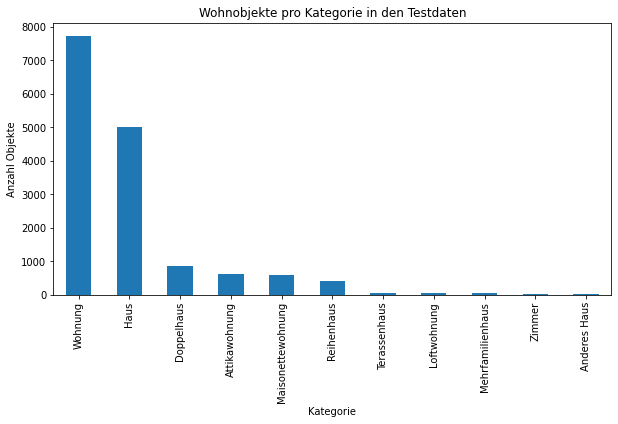

In [39]:
y_test.value_counts().plot(kind='bar', figsize=(10, 5), rot = 90)
plt.xlabel("Kategorie")
plt.ylabel("Anzahl Objekte")
plt.title("Wohnobjekte pro Kategorie in den Testdaten")
plt.show()

Aus diesem Grund ist die Precision in diesen beiden Kategorien so viel höher als bei den anderen.

Beim Recall sieht es etwas anders aus. Da in diesem die False Negatives mit einfliessen, liegen die Werte näher beieinander. Er beschreibt wie viele, der als richtig klassifizierten Objekte, tatsächlich richtig klassifiziert worden sind. Bei der Kategorie *Wohnung* ist der Wert mit 0.37 eher niederig. Die Erklärung hierfür ist, dass das Model durch die Klassenungleichheit in den Trainingsdaten einen starken Bias entwickelt. Darum werden viele Nicht-Wohnungen als Wohnungen klassifiziert.

Der F1-Score ist das harmonische Mittel von Precision und Recall, er zieht also False Positives und False Negatives mit in Betracht. Hier haben die beiden Kategorien *Haus* und *Wohnung* wieder die besten Scores. Grund hierfür ist der unterliegende gute Wert der Precision.

## Bestes Modell

In [40]:
print(sklearn.metrics.classification_report(y_test, lgbc_y_pred_best))

                   precision    recall  f1-score   support

     Anderes Haus       0.00      0.00      0.00         3
    Attikawohnung       0.32      0.69      0.43       620
       Doppelhaus       0.38      0.60      0.47       846
             Haus       0.92      0.79      0.85      5007
      Loftwohnung       0.35      0.50      0.41        48
Maisonettewohnung       0.28      0.58      0.37       583
 Mehrfamilienhaus       0.27      0.58      0.37        36
       Reihenhaus       0.40      0.60      0.48       417
     Terassenhaus       0.60      0.54      0.57        56
          Wohnung       0.95      0.78      0.86      7741
           Zimmer       0.00      0.00      0.00         5

         accuracy                           0.75     15362
        macro avg       0.41      0.51      0.44     15362
     weighted avg       0.84      0.75      0.78     15362



Bei der Precision fällt direkt auf, dass die Werte näher beieinander liegen als voher. *Wohnung* und *Haus* sind immer noch oben mit dabei, aber jetzt gibt es sogar noch eine bessere Kategorie. *Anderes Haus* hat eine Precision von 1.00! Wenn man sich aber den Recall anschaut, sieht man, dass diese Klassifikation nicht perfekt ist. Die Precision von 1.00 sagt uns, dass es keine False Positives gibt. Der Recall sagt uns aber, dass es False Negatives gibt. Für die Werte 1.00 und 0.33 bei einer Gesamtzahl von 3 Objekten in dieser Kategorie bedeutet das: 1 Objekt wurde richtigerweise als *Anderes Haus* klassifiert und 2 aus der Kategorie wurden falsch eingeordnet.

Betrachtet man den F1-Score, haben sich die Werte in jeder Kategorie drastisch verbessert. *Haus* und *Wohnung* sind immer noch die beiden besten Kategorien, jedoch sind alle anderen Werte jetzt viel näher dran.

## Confusion Matrix

Die Matrix ist über die *richtigen* Klassifizierungen hinweg normalisiert. Das bedeutet, dass die Werte in jeder Zeile in der Matrix zusammenaddiert 1.0 ergeben. Man kann herauslesen, wie viele Objekte (prozentual) in welche andere Klasse eingeordnet wurden. 

Beispiel: *Anderes Haus* in der ersten Zeile. Wir sehen im Schnittpunkt von *Anderes Haus* auf der x-Achse und *Anderes Haus* auf der y-Achse einen Wert von 0.33. Das bedeutet ein Drittel der Objekte wurden auch so klassifiziert. Bei *Doppel Haus* auf der x-Achse und *Anderes Haus* auf der y-Achse sieht man, ein weiteres Drittel wurde fälschlicherweise als *Doppelhaus* klassifiziert.

Insgesammt kann man sehen, dass die meisten Objekte der jeweiligen Klasse korrekt eingestuft worden sind (Diagonale von links oben nach rechts unten). Trotzdem werden viele Objekte noch falsch und überall verteilt eingeordnet.

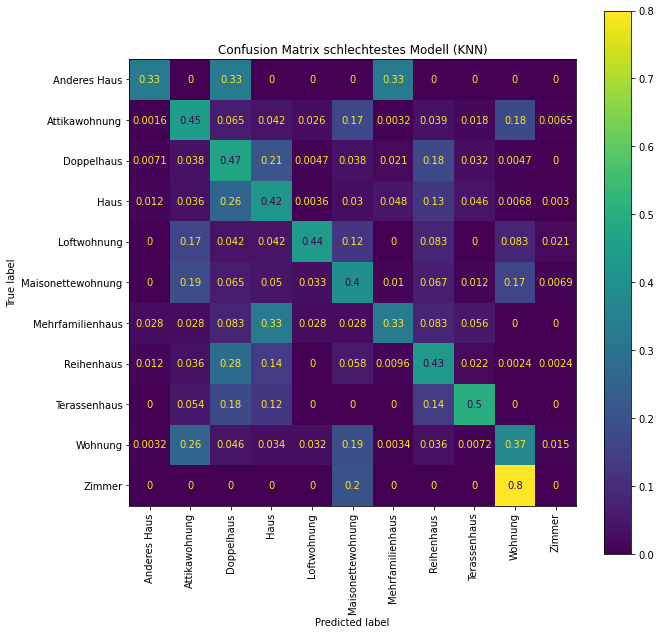

In [41]:
fig, ax = plt.subplots(figsize=(10, 10))
sklearn.metrics.plot_confusion_matrix(knn_smote, X_test, y_test, normalize = 'true', xticks_rotation='vertical', ax = ax)
plt.title('Confusion Matrix schlechtestes Modell (KNN)')
plt.show()

Beim besten Modell sieht das etwas anders aus. Insgesamt ist die Streuung der falsch klassifizierten Objekte kleiner geworden. Es gibt aber einige (nachvollziehbare) Ausreisser: 

- 67% der Kategorie *Anderes Haus* wurden als *Haus* klassifiziert
- 86% der *Zimmer* wurden als *Wohnung* eingeordnet.

Text(0.5, 1.0, 'Confusion Matrix optimiertes Modell (LightGBM)')

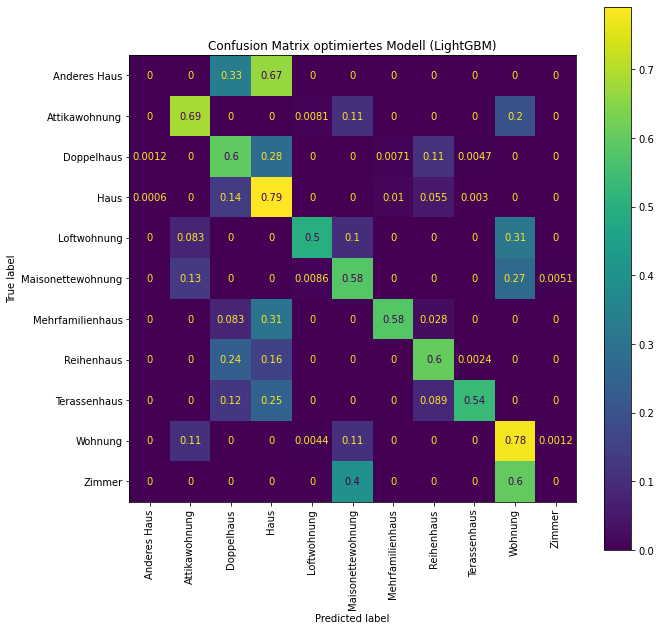

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
sklearn.metrics.plot_confusion_matrix(lgbc_best, X_test, y_test, normalize = 'true', xticks_rotation='vertical', ax = ax)
plt.title('Confusion Matrix optimiertes Modell (LightGBM)')

Alles in allem kann man sehen, dass sich die verschiedenen Optimierungstechnicken (Resampling, Hyperparamether tuning) ausgezahlt haben.